# 分析
切り出したショットデータを取得し、分析します。  
以下は特定ショットのデータを取得/確認し、特徴点（荷重開始点/最大荷重点/破断点）を抽出、その後全ショットに対して特徴点を抽出するサンプルコードです。

In [1]:
# ライブラリインポート
import os, sys
sys.path.append(os.path.join(os.getcwd(), '../src/'))
from data_reader.data_reader import DataReader
from elastic_manager.elastic_manager import ElasticManager
sys.path.append(os.path.join(os.getcwd(), '../src/analyze/'))
from analyze.h_one_extract_features import *
from analyze.analyze import *

Loading BokehJS ...

In [2]:
# ログ設定
LOG_FILE = os.path.join(
    common.get_config_value(common.APP_CONFIG_PATH, "log_dir"), "analyze/analyze.log"
)

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        logging.handlers.RotatingFileHandler(
            LOG_FILE, maxBytes=common.MAX_LOG_SIZE, backupCount=common.BACKUP_COUNT
        ),
        logging.StreamHandler(),
    ],
)

In [3]:
# ショットデータインデックス一覧
ElasticManager.show_indices(index="shots-*-data")

,index,docs.count,store.size
0,shots-20201201010000-data,9655193,1285672
1,shots-20210201151814-data,0,0
2,shots-fixed-data,0,0


In [4]:
# 対象データ設定
target = "20201201010000"
shots_data_index = "shots-" + target + "-data"
shots_meta_index = "shots-" + target + "-meta"

In [5]:
# 最初のショットを取得して確認
dr = DataReader()

shot_number = 1
shot_df = dr.read_shot(shots_data_index, shot_number=shot_number)
shot_df.head()

,timestamp,sequential_number,sequential_number_by_shot,displacement,load01,load02,load03,load04,shot_number,tags
0,1.606752e+09,0,0,49.171,0.568421,0.526316,0.597368,0.502632,1,"[異常A, 異常B]"
1,1.606752e+09,1,1,49.245,0.550000,0.526316,0.623684,0.507895,1,"[異常A, 異常B]"
2,1.606752e+09,2,2,49.136,0.568421,0.510526,0.660526,0.521053,1,"[異常A, 異常B]"
3,1.606752e+09,3,3,49.184,0.600000,0.502632,0.678947,0.521053,1,"[異常A, 異常B]"
4,1.606752e+09,4,4,49.149,0.578947,0.473684,0.671053,0.521053,1,"[異常A, 異常B]"


In [6]:
# ショットメタデータを確認
shots_meta_df = dr.read_shots_meta(shots_meta_index)
shots_meta_df.head()

,shot_number,spm,num_of_samples_in_cut_out
0,1,80.598572,3125.0
1,2,80.613753,3113.0
2,3,80.594235,3129.0
3,4,80.636509,3097.0
4,5,80.582338,3140.0


In [7]:
# ショットの数を確認
print(f"ショット数：{len(shots_meta_df)}")

ショット数：3098


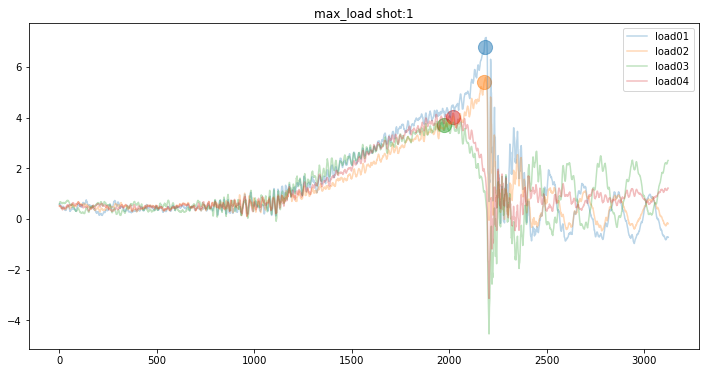

2021-02-10 09:53:13,307 [INFO] NumExpr defaulting to 8 threads.


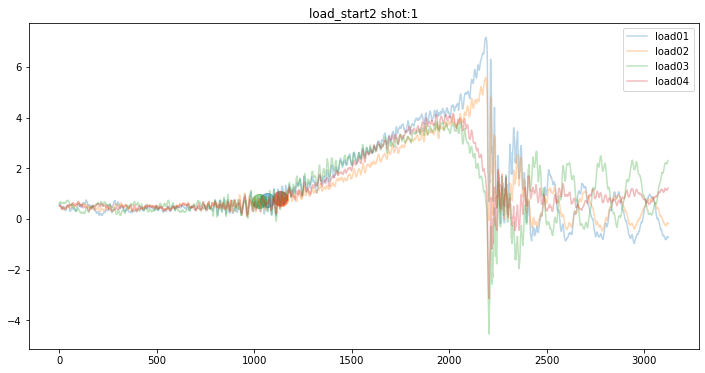

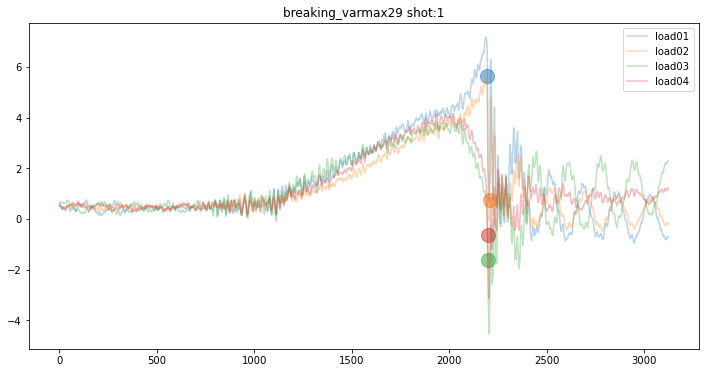

In [8]:
# 最初のショットの最大荷重点、荷重開始点、破断点を確認
max_load_indicies, max_load_values, debug_values = extract_features(shot_df, 80.0, max_load, shot=shot_number, disp_chart=True)
load_start_indicies, load_start_values, debug_values = extract_features(shot_df, 80.0, load_start2, shot=shot_number, disp_chart=True)
break_load_indicies, break_load_values, debug_values = extract_features(shot_df, 80.0, breaking_varmax29, shot=shot_number, disp_chart=True)

In [9]:
# 各特徴点のインデックス番号と値を確認
print(f"最大荷重点：{max_load_indicies}, {max_load_values}")
print(f"荷重開始点：{load_start_indicies}, {load_start_values}")
print(f"破断点　　：{break_load_indicies}, {break_load_values}")

最大荷重点：[2182, 2181, 1975, 2019], [6.78550459074001, 5.385646033598365, 3.7044956834496174, 4.012291677905753]
荷重開始点：[1064, 1136, 1026, 1133], [0.7440113441498473, 0.7840786175966226, 0.6914523149980218, 0.8086664028492289]
破断点　　：[2197, 2208, 2198, 2198], [5.644736842105263, 0.7499999999999991, -1.6315789473684146, -0.6289473684210495]


## データ読み込み
指定したインデックスの全ショットデータをメモリ上に読み込みます。これには時間がかかります。  
時間目安：10,000,000件読み込みで約3分

In [10]:
%%time
# 全ショットデータ読み込み
target = "20201201010000"
shots_data_index = "shots-" + target + "-data"

dr = DataReader()
shots_df = dr.multi_process_read_all(shots_data_index)

2021-02-10 09:53:19,667 [INFO] データを全件取得します。データ件数が多い場合、長時間かかる場合があります。
2021-02-10 09:53:19,670 [INFO] データ件数: 9655193
2021-02-10 09:53:19,671 [INFO] Data read start. data_count: 9655193.


CPU times: user 1min 5s, sys: 4.07 s, total: 1min 9s
Wall time: 3min 14s


In [11]:
# ショットメタデータ読み込み
shots_meta_index = "shots-" + target + "-meta"
shots_meta_df = dr.read_shots_meta(shots_meta_index)

## 全ショットから特徴点抽出
全ショットから最大荷重点、荷重開始点、破断点を抽出し、Elasticsearchに保存します。  

***target***: 対象ショットデータ（yyyyMMddHHMMSS）  
***shots_df***: ショットデータ  
***shots_meta_df***: ショットメタデータ  
***feature***: 特徴点名（max/start/break）  
***func***：適用するロジック  
***func***：適用するサブロジック  

保存先インデックスは以下になります。  
* 最大荷重点：shots-yyyyMMddHHMMSS-max-point
* 荷重開始点：shots-yyyyMMddHHMMSS-start-point
* 破断点：shots-yyyyMMddHHMMSS-break-point

In [12]:
# 最大荷重点
apply(
    target=target,
    shots_df=shots_df,
    shots_meta_df=shots_meta_df,
    feature="max",
    func=ef.max_load,
    sub_func=None,
)

2021-02-10 10:02:47,774 [INFO] apply start.
2021-02-10 10:02:47,844 [INFO] delete index 'shots-20201201010000-max-point' finished. result: {'acknowledged': True}
2021-02-10 10:03:04,662 [INFO] apply finished.


In [13]:
# 荷重開始点
apply(
    target="20201201010000",
    shots_df=shots_df,
    shots_meta_df=shots_meta_df,
    feature="start",
    func=ef.load_start2,
    sub_func=None,
)

2021-02-10 10:03:58,335 [INFO] apply start.
2021-02-10 10:03:58,416 [INFO] delete index 'shots-20201201010000-start-point' finished. result: {'acknowledged': True}
2021-02-10 10:04:24,171 [INFO] apply finished.


In [14]:
# 破断点
apply(
    target="20201201010000",
    shots_df=shots_df,
    shots_meta_df=shots_meta_df,
    feature="break",
    func=ef.breaking_var_vrms,
    sub_func=ef.narrowing_var_ch,
)

2021-02-10 10:04:26,213 [INFO] apply start.
2021-02-10 10:04:26,278 [INFO] delete index 'shots-20201201010000-break-point' finished. result: {'acknowledged': True}
2021-02-10 10:06:43,717 [INFO] apply finished.
